In [10]:
import pandas as pd

data_source = './data/beer_profile_and_ratings.csv'

#df = pd.read_csv(data_source)
df = pd.read_table(data_source, delimiter=',')
def trim_style(style):
    if '-' in style:
        return style.split('-')[0].strip()
    return style

df['Style'] = df['Style'].apply(trim_style)
unique_styles = df['Style'].unique()

#df.head()

In [11]:
import numpy as np
from scipy.stats import chi2

numeric_features = ['ABV', 'Min IBU', 'Max IBU']

def mahalanobis_dist(df, features):
    X = df[features].values
    mean = np.mean(X, axis=0)
    cov = np.cov(X, rowvar=False)
    
    try:
        cov_inv = np.linalg.inv(cov)
    except np.linalg.LinAlgError:
        cov_inv = np.linalg.pinv(cov)  # Используем псевдообратную матрицу если обычная вырождена
    
    deviations = X - mean
    distances = np.sqrt(np.sum(deviations.dot(cov_inv) * deviations, axis=1))
    return distances

# Вычисляем расстояния
distances = mahalanobis_dist(df, numeric_features)

threshold = chi2.ppf(0.95, df=len(numeric_features))  # 95% доверительный интервал

outliers_mask = distances > np.sqrt(threshold)
outliers = df[outliers_mask]

original_size = len(df)
df_clean = df[~outliers_mask]

df = df_clean.copy()

In [12]:
import numpy as np
import pandas as pd

%matplotlib inline

import seaborn as sns
from matplotlib import pyplot as plt

features = ['ABV', 'Min IBU', 'Max IBU', 'Astringency', 'Body', 'Alcohol', 
            'Bitter', 'Sweet', 'Sour', 'Salty', 'Fruits', 'Hoppy', 'Spices', 'Malty']
dx = df[features]  # Признаки
dy = df['Style']   # Целевая переменная (стиль пива)

print(dx.head())
print(dy.head())

   ABV  Min IBU  Max IBU  Astringency  Body  Alcohol  Bitter  Sweet  Sour  \
0  5.3       25       50           13    32        9      47     74    33   
1  7.2       25       50           12    57       18      33     55    16   
2  5.0       25       50           14    37        6      42     43    11   
3  8.5       25       50           13    55       31      47    101    18   
4  7.2       25       50           25    51       26      44     45     9   

   Salty  Fruits  Hoppy  Spices  Malty  
0      0      33     57       8    111  
1      0      24     35      12     84  
2      0      10     54       4     62  
3      1      49     40      16    119  
4      1      11     51      20     95  
0    Altbier
1    Altbier
2    Altbier
3    Altbier
4    Altbier
Name: Style, dtype: object


In [13]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

excluded_features = [
    'review_aroma', 'review_appearance', 'review_palate',
    'review_taste', 'review_overall', 'number_of_reviews'
]

features = [
    'ABV', 'Min IBU', 'Max IBU', 'Astringency', 'Body', 'Alcohol', 
    'Bitter', 'Sweet', 'Sour', 'Salty', 'Fruits', 'Hoppy', 'Spices', 'Malty'
] + excluded_features

df[excluded_features] = df[excluded_features].astype(float)

X = df[features]  # Признаки
y = df['Style']   # Целевая переменная (стиль пива)

X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.2, random_state=42)
X_holdout.loc[:, excluded_features] = np.nan

tree = DecisionTreeClassifier(max_depth=12, random_state=21, max_features=3)
tree.fit(X_train, y_train)

tree_pred = tree.predict(X_holdout)

accur = accuracy_score(y_holdout, tree_pred)
print(f'Точность модели: {accur:.2f}')

Точность модели: 0.50


C:\Users\fatop\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\fatop\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\fatop\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\fatop\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\si

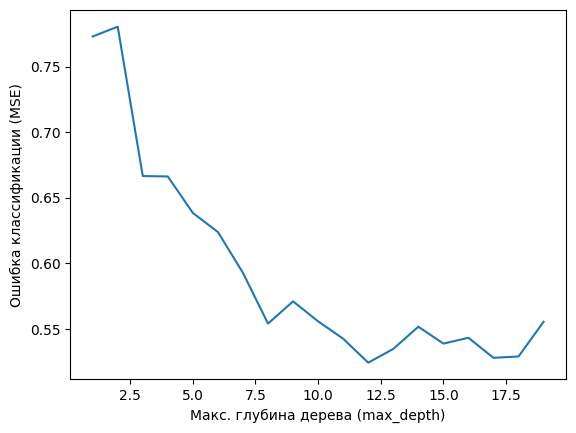

Оптимальные значения max_depth:  [12]


In [14]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

excluded_features = [
    'review_aroma', 'review_appearance', 'review_palate',
    'review_taste', 'review_overall', 'number_of_reviews'
]

features = [
    'ABV', 'Min IBU', 'Max IBU', 'Astringency', 'Body', 'Alcohol', 
    'Bitter', 'Sweet', 'Sour', 'Salty', 'Fruits', 'Hoppy', 'Spices', 'Malty'
] + excluded_features

df[excluded_features] = df[excluded_features].astype(float)

X = df[features]  # Признаки
y = df['Style']   # Целевая переменная (стиль пива)

# Значения параметра max_depth
d_list = list(range(1, 20))
# Пустой список для хранения значений точности
cv_scores = []

for d in d_list:
    tree = DecisionTreeClassifier(max_depth=d, random_state=21, max_features=3)
    scores = cross_val_score(tree, X, y, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

MSE = [1 - x for x in cv_scores]

plt.plot(d_list, MSE)
plt.xlabel('Макс. глубина дерева (max_depth)')
plt.ylabel('Ошибка классификации (MSE)')
plt.show()

d_min = min(MSE)

all_d_min = []
for i in range(len(MSE)):
    if MSE[i] <= d_min:
        all_d_min.append(d_list[i])

print('Оптимальные значения max_depth: ', all_d_min)

C:\Users\fatop\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\fatop\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\fatop\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\fatop\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\si

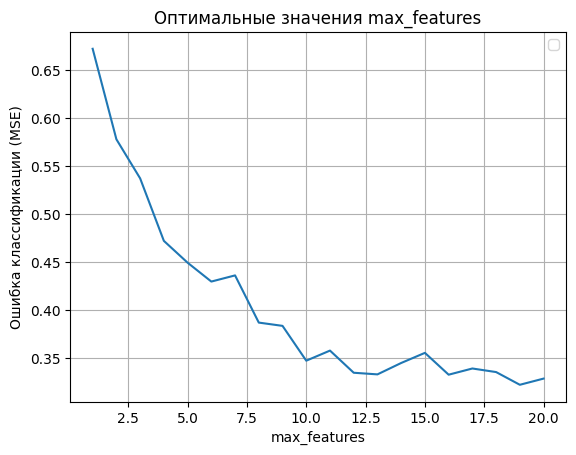

Оптимальные значения max_features:  19


In [28]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

excluded_features = [
    'review_aroma', 'review_appearance', 'review_palate',
    'review_taste', 'review_overall', 'number_of_reviews'
]

features = [
    'ABV', 'Min IBU', 'Max IBU', 'Astringency', 'Body', 'Alcohol', 
    'Bitter', 'Sweet', 'Sour', 'Salty', 'Fruits', 'Hoppy', 'Spices', 'Malty'
] + excluded_features

df[excluded_features] = df[excluded_features].astype(float)

X = df[features]
y = df['Style']

max_features_list = list(range(1, len(features) + 1))
mse_scores = []

for max_features in max_features_list:
    tree = DecisionTreeClassifier(max_features=max_features, random_state=21)
    scores = cross_val_score(tree, X, y, cv=10, scoring='accuracy')
    mse = 1 - scores.mean()
    mse_scores.append(mse)

plt.plot(max_features_list, mse_scores)
plt.xlabel('max_features')
plt.ylabel('Ошибка классификации (MSE)')
plt.title('Оптимальные значения max_features')
plt.grid(True)

mse_min = min(mse_scores)
optimal_max_features = max_features_list[mse_scores.index(mse_min)]
plt.legend()

plt.show()

print('Оптимальные значения max_features: ', optimal_max_features)

In [29]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import pandas as pd

excluded_features = [
    'review_aroma', 'review_appearance', 'review_palate',
    'review_taste', 'review_overall', 'number_of_reviews'
]

features = [
    'ABV', 'Min IBU', 'Max IBU', 'Astringency', 'Body', 'Alcohol', 
    'Bitter', 'Sweet', 'Sour', 'Salty', 'Fruits', 'Hoppy', 'Spices', 'Malty'
] + excluded_features

X = df[features]  # Признаки
y = df['Style']   # Целевая переменная (стиль пива)

dtc = DecisionTreeClassifier(max_depth=12, random_state=21, max_features=19)

tree_params = {
    'max_depth': range(1, 20),
    'max_features': range(1, 20)
}

tree_grid = GridSearchCV(dtc, tree_params, cv=10, verbose=True, n_jobs=-1)
tree_grid.fit(X, y)

print('\nЛучшие параметры: ', tree_grid.best_params_)
print('Лучшая точность cross validation: ', tree_grid.best_score_)

export_graphviz(
    tree_grid.best_estimator_,
    feature_names=X.columns,
    class_names=y.unique(),
    out_file='./files/beer_tree.dot',
    filled=True,
    rounded=True
)

Fitting 10 folds for each of 361 candidates, totalling 3610 fits


C:\Users\fatop\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=10.
  warnings.warn(



Лучшие параметры:  {'max_depth': 13, 'max_features': 17}
Лучшая точность cross validation:  0.6838250114521301


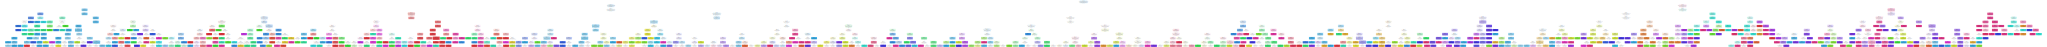

In [20]:
from graphviz import Source

with open('./files/beer_tree.dot', 'r') as f:
    dot_code = f.read()
source = Source(dot_code)
source



In [17]:
from sklearn.tree import DecisionTreeClassifier

excluded_features = [
    'review_aroma', 'review_appearance', 'review_palate',
    'review_taste', 'review_overall', 'number_of_reviews'
]

features = [
    'ABV', 'Min IBU', 'Max IBU', 'Astringency', 'Body', 'Alcohol', 
    'Bitter', 'Sweet', 'Sour', 'Salty', 'Fruits', 'Hoppy', 'Spices', 'Malty'
] + excluded_features

X = df[features]  # Признаки
y = df['Style']   # Целевая переменная (стиль пива)

dtc = DecisionTreeClassifier(max_depth=12, random_state=21, max_features=3)
dtc.fit(X, y)

# Dunkel Lager,Lager - Munich Dunkel,Sly Fox Brewing Company,Sly Fox Brewing Company Dunkel Lager,Notes:,5.3,15,25,25,49,8,29,81,15,2,18,38,9,132,3.472973,3.644144,3.612613,3.554054,3.806306,111
new_sample = [[5.3,15,25,25,49,8,29,81,15,2,18,38,9,132,3.472973,3.644144,3.612613,3.554054,3.806306,111]]
res = dtc.predict(new_sample)
print(res)

['Lager']


C:\Users\fatop\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


C:\Users\fatop\AppData\Local\Temp\ipykernel_9672\3651560451.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  xx, yy = np.meshgrid(np.arange(fmin[i], fmax[i], plot_step),
C:\Users\fatop\AppData\Local\Temp\ipykernel_9672\3651560451.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.arange(fmin[j], fmax[j], plot_step))
C:\Users\fatop\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


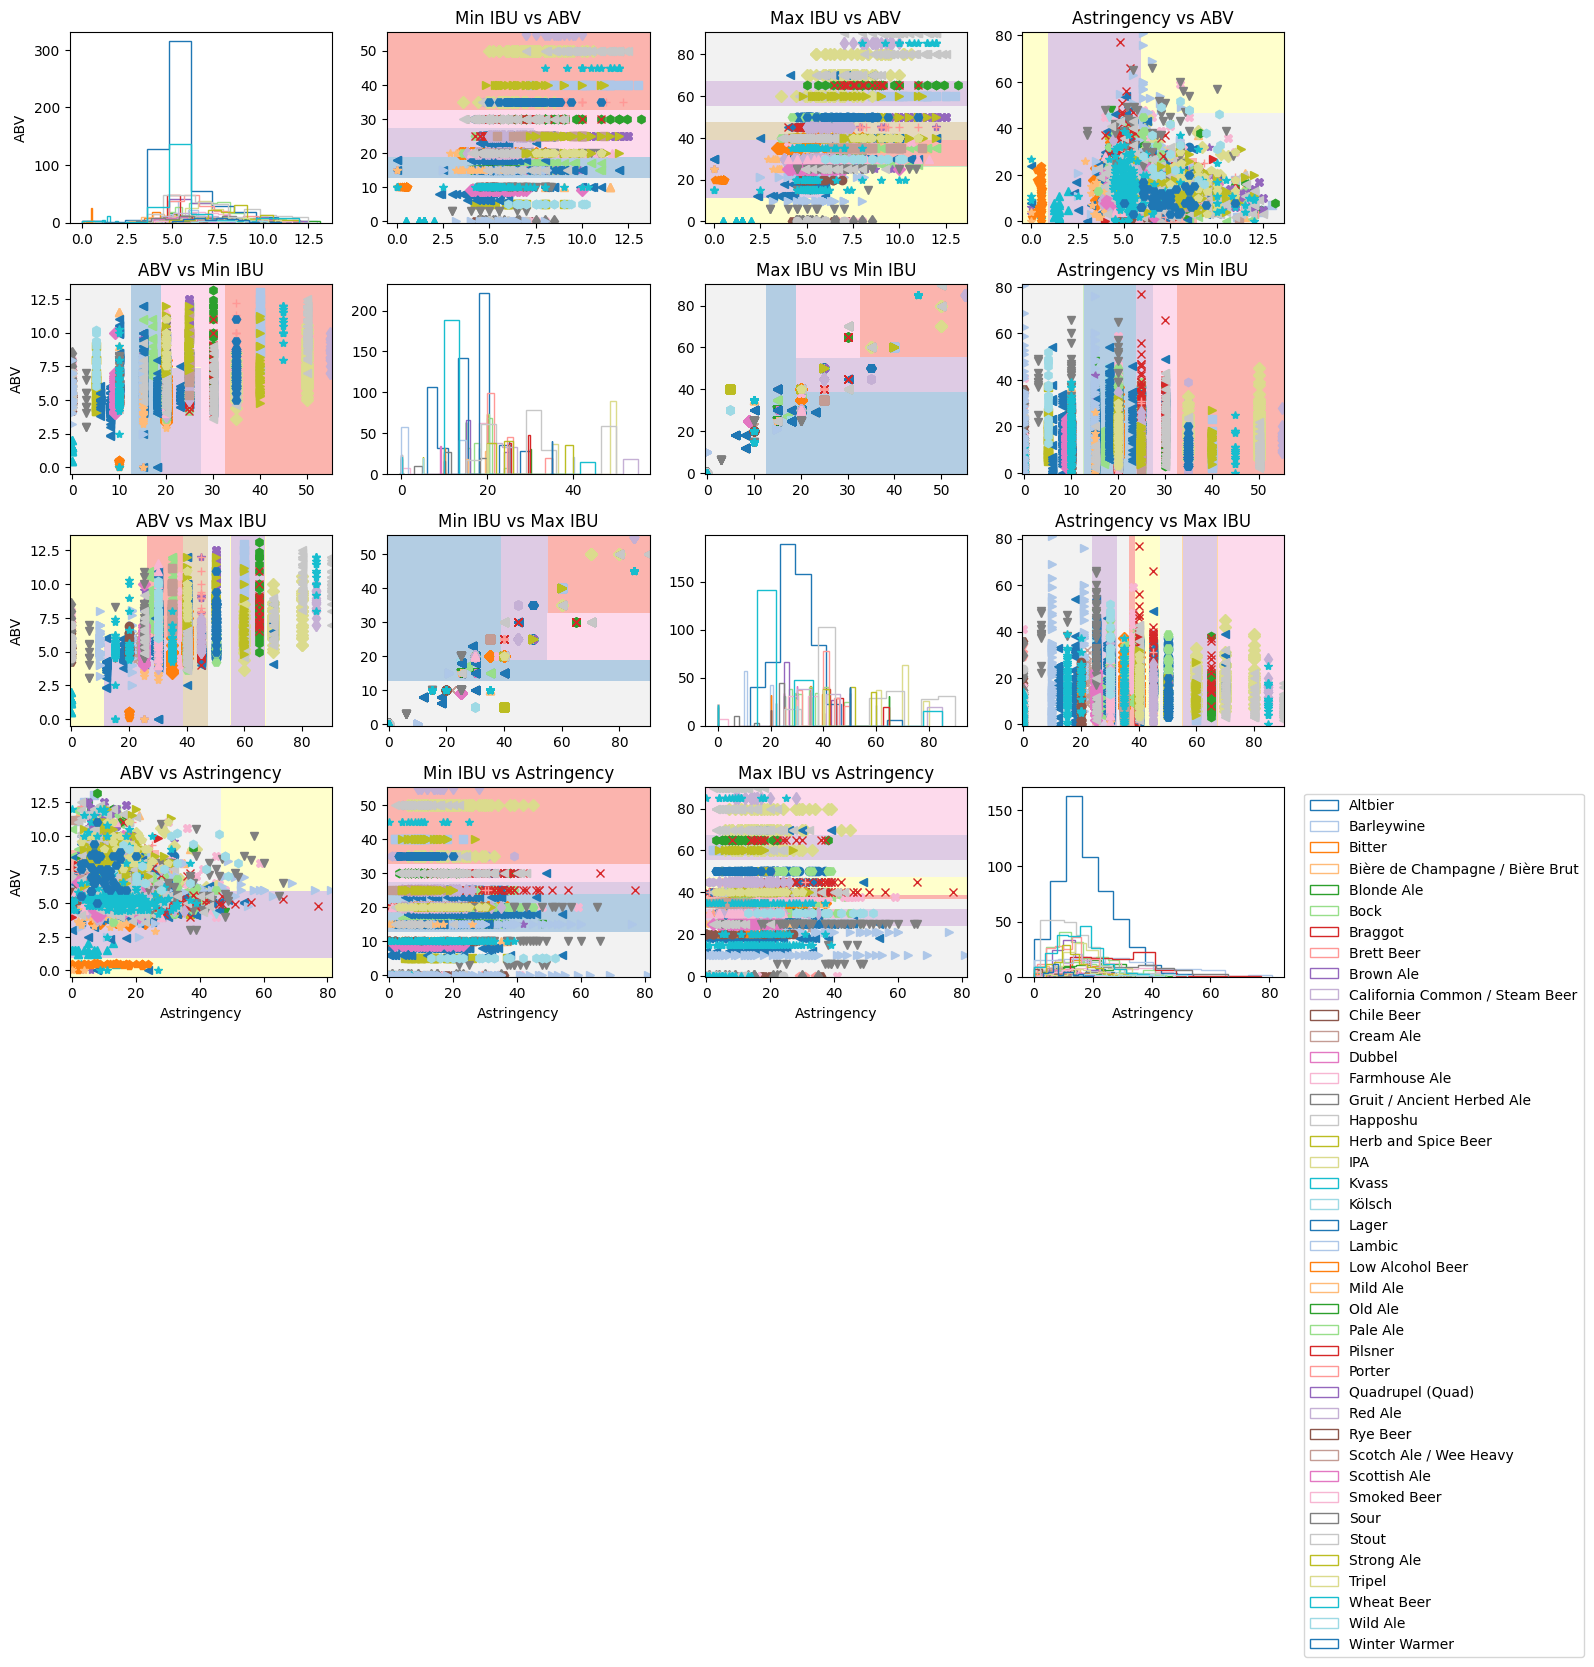

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier

excluded_features = [
    'review_aroma', 'review_appearance', 'review_palate',
    'review_taste', 'review_overall', 'number_of_reviews'
]

features = [
    'ABV', 'Min IBU', 'Max IBU', 'Astringency', 'Body', 'Alcohol', 
    'Bitter', 'Sweet', 'Sour', 'Salty', 'Fruits', 'Hoppy', 'Spices', 'Malty'
]

X = df[features]
y = df['Style']

answers = y.unique()

# Преобразуем метки классов в числовые значения
label_to_num = {label: idx for idx, label in enumerate(answers)}
y_numeric = y.map(label_to_num)

# Динамическое создание маркеров
markers = ['o', 's', 'D', '^', 'v', '<', '>', 'p', '*', 'h', 'H', 'x', '+', 'X', 'd']
colors = plt.cm.tab20.colors  # Используем цветовую карту для большого количества цветов

f, places = plt.subplots(4, 4, figsize=(16, 16))

fmin = X.min() - 0.5
fmax = X.max() + 0.5
plot_step = 0.02

for i in range(4):
    for j in range(4):
        if i != j:
            xx, yy = np.meshgrid(np.arange(fmin[i], fmax[i], plot_step),
                                np.arange(fmin[j], fmax[j], plot_step))
            model = DecisionTreeClassifier(max_depth=3, random_state=21, max_features=2)
            model.fit(X.iloc[:, [i, j]], y_numeric)
            p = model.predict(np.c_[xx.ravel(), yy.ravel()])
            p = p.reshape(xx.shape)
            places[i, j].contourf(xx, yy, p, cmap='Pastel1')  # Используем 'Pastel1'

        for id_answer, answer in enumerate(answers):
            idx = np.where(y == answer)
            if i == j:
                places[i, j].hist(X.iloc[idx].iloc[:, i],
                                 color=colors[id_answer % len(colors)],
                                 histtype='step')
            else:
                places[i, j].plot(X.iloc[idx].iloc[:, i], X.iloc[idx].iloc[:, j],
                                 marker=markers[id_answer % len(markers)],
                                 color=colors[id_answer % len(colors)],
                                 linestyle='None',
                                 label=answer, markersize=6)

        # Подписи осей
        if j == 0:
            places[i, j].set_ylabel(features[j])
        if i == 3:
            places[i, j].set_xlabel(features[i])

        # Добавляем заголовок для каждой ячейки
        if i != j:
            places[i, j].set_title(f"{features[j]} vs {features[i]}")

# Легенда
plt.legend(answers, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()